# Метод обратного распространения ошибки для двуслойной полностью связной нейронной сети

### Считывание данных:

In [1]:
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

def getImages(name):
    filename = 'data/' + name
    with open(filename, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
    return data

def getLabels(name):
    filename = 'data/' + name
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size,)) 
    return data

In [2]:
train_images = getImages('train-images.idx3-ubyte')
train_labels = getLabels('train-labels.idx1-ubyte')

test_images = getImages('t10k-images.idx3-ubyte')
test_labels = getLabels('t10k-labels.idx1-ubyte')

### Проверка корректности считанных данных

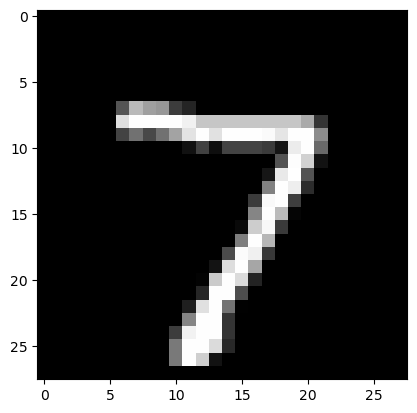

In [3]:
plt.imshow(test_images[0], cmap='gray')

In [4]:
test_labels[0]

7

### Нормировка данных



In [5]:
# flatten 28x28 to 784x1 vectors, [60000, 784]
train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32')
train_images /= 255  # normalization
train_labels = np.eye(10)[train_labels]  # convert label to one-hot

test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32')
test_images /= 255  # normalization
test_labels = np.eye(10)[test_labels] # convert label to one-hot

In [6]:
def cross_entropy_loss(predicted, actual):
    return np.mean(-np.sum(actual * np.log(predicted), axis=1))

def compute_accuracy(predicted, actual):
    return np.mean(np.argmax(predicted, axis=1) == np.argmax(actual, axis=1))

def relu(x):
    return np.maximum(x, 0)

def reludx(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def softmax(x):
    exp_scores = np.exp(x)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

class NN():
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, batch_size = 8):
        # Initialize weights
        self.w1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.w2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)

        # Initialize biases
        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, output_size))

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = output_size
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        # fc = ReLU(x * w1 + b1)
        self.x1 = np.dot(x, self.w1) + self.b1
        self.fc = relu(self.x1)

        # out = softmax(fc * w2 + b2)
        self.x2 = np.dot(self.fc, self.w2) + self.b2
        self.out = softmax(self.x2)
        return self.out
    
    def backward(self, x, y):
        # dx2 = -(1 / batch_size) * (y - out) 
        dx2 = (self.out - y) / self.out.shape[0]

        # dx1 = ReLUdx(dx2 * w2.T)
        dx1 = np.dot(dx2, self.w2.T) * reludx(self.x1)

        # dw2 = fc.t * dx2
        dw2 = np.dot(self.fc.T, dx2)

        # dw1 = x.T * dx1
        dw1 = np.dot(x.T, dx1)

        # db2 = sum(dx2)
        db2 = np.sum(dx2, axis=0, keepdims=True)

        # db1 = sum(dx1)
        db1 = np.sum(dx1, axis=0, keepdims=True)

        # Update weights and biases
        self.w1 += -self.lr * dw1
        self.b1 += -self.lr * db1
        self.w2 += -self.lr * dw2
        self.b2 += -self.lr * db2



    def train(self, train, test, num_epochs=4):
        tStart = timer()
        train_images, train_labels = train
        test_images, test_labels = test
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2

        for epoch in range(num_epochs):
            i = 0
            while i < len(train_images):
                train_batch = train_images[i : i + self.batch_size]
                labels_batch = train_labels[i : i + self.batch_size]

                output = self.forward(train_batch)
                error = cross_entropy_loss(output, labels_batch)
                self.backward(train_batch, labels_batch)
                i += self.batch_size

            
            error_test = cross_entropy_loss(self.forward(test_images), test_labels)
            error_train = cross_entropy_loss(self.forward(train_images), train_labels)
            acc_test = compute_accuracy(self.forward(test_images), test_labels)
            acc_train = compute_accuracy(self.forward(train_images), train_labels)
            
            print(f"Epoch {epoch} - Error on test: {error_test:.5f}; Error on train: {error_train:.5f}; Accuracy on test: {acc_test:.5f}; Accuracy on train: {acc_train:.5f}")
        tEnd = timer()
        error_test = cross_entropy_loss(self.forward(test_images), test_labels)
        error_train = cross_entropy_loss(self.forward(train_images), train_labels)
        
        acc_test = compute_accuracy(self.forward(test_images), test_labels)
        acc_train = compute_accuracy(self.forward(train_images), train_labels)

        print("Result:")
        print(f"Error on test: {error_test:.5f}; Error on train: {error_train:.5f}; Accuracy on test: {acc_test:.5f}; Accuracy on train: {acc_train:.5f}; Time: {tEnd - tStart:.2f} s")
    
    def test(self, x_test):
        return self.forward(x_test)
        

Создадим экземпляр нейронной сети и запустим обучение:

In [7]:
network = NN(input_size=784, hidden_size=300, output_size=10, lr = 0.1, batch_size = 8)

network.train((train_images, train_labels), (test_images, test_labels), num_epochs=20)

Epoch 0 - Error on test: 0.13110; Error on train: 0.11548; Accuracy on test: 0.95910; Accuracy on train: 0.96355
Epoch 1 - Error on test: 0.10742; Error on train: 0.07491; Accuracy on test: 0.96750; Accuracy on train: 0.97587
Epoch 2 - Error on test: 0.08901; Error on train: 0.04890; Accuracy on test: 0.97390; Accuracy on train: 0.98418
Epoch 3 - Error on test: 0.09334; Error on train: 0.04165; Accuracy on test: 0.97250; Accuracy on train: 0.98637
Epoch 4 - Error on test: 0.09268; Error on train: 0.03447; Accuracy on test: 0.97390; Accuracy on train: 0.98858
Epoch 5 - Error on test: 0.09262; Error on train: 0.02946; Accuracy on test: 0.97480; Accuracy on train: 0.99005
Epoch 6 - Error on test: 0.08351; Error on train: 0.01957; Accuracy on test: 0.97730; Accuracy on train: 0.99320
Epoch 7 - Error on test: 0.08526; Error on train: 0.01612; Accuracy on test: 0.97590; Accuracy on train: 0.99450
Epoch 8 - Error on test: 0.08262; Error on train: 0.01176; Accuracy on test: 0.97820; Accuracy o

Let's test the network

In [8]:
compute_accuracy(network.test(test_images), test_labels)

0.9829

### Let's compare these results with ones of Torch network

In [9]:
import torch
from torch import nn
import torch.optim as optim

input_size = 28*28
hidden_size = 300
output_size = 10
batch_size = 8
num_epochs = 20

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        out = self.softmax(x)
        return out

In [10]:
torch_network = TorchNN()
print(torch_network)

TorchNN(
  (layer1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=300, out_features=10, bias=True)
  (softmax): Softmax(dim=0)
)


In [11]:
optimizer = optim.SGD(torch_network.parameters(), lr=0.1)
loss_func = nn.CrossEntropyLoss()

In [12]:
def train_torch(nn, train, test, loss, optimizer, batch_size, num_epochs):
    tStart = timer()

    for epoch in range(num_epochs):
        i = 0
        while i < len(train_images):
            train_batch = torch.tensor(train_images[i:i + batch_size])
            labels_batch = torch.tensor(train_labels[i:i + batch_size])

            optimizer.zero_grad()
            net_out = torch_network(train_batch)
            loss = loss_func(net_out, labels_batch)
            loss.backward()
            optimizer.step()

            i += batch_size
        
        accuracy_train = compute_accuracy(torch_network(torch.tensor(train_images)).detach().numpy(), train_labels)
        accuracy_test = compute_accuracy(torch_network(torch.tensor(test_images)).detach().numpy(), test_labels)
        print(f"Epoch {epoch} - Train accuracy: {accuracy_train:.5f}; Test accuracy: {accuracy_test:.5f}")

    tEnd = timer()
    return tEnd - tStart

In [13]:
torch_time = train_torch(torch_network, (train_images, train_labels), (test_images, test_labels), loss_func, optimizer, batch_size, num_epochs)

Epoch 0 - Train accuracy: 0.86303; Test accuracy: 0.87100
Epoch 1 - Train accuracy: 0.91177; Test accuracy: 0.91550
Epoch 2 - Train accuracy: 0.93660; Test accuracy: 0.93850
Epoch 3 - Train accuracy: 0.94922; Test accuracy: 0.95150
Epoch 4 - Train accuracy: 0.95707; Test accuracy: 0.95760
Epoch 5 - Train accuracy: 0.96230; Test accuracy: 0.96060
Epoch 6 - Train accuracy: 0.96558; Test accuracy: 0.96430
Epoch 7 - Train accuracy: 0.96803; Test accuracy: 0.96640
Epoch 8 - Train accuracy: 0.96992; Test accuracy: 0.96840
Epoch 9 - Train accuracy: 0.97185; Test accuracy: 0.97040
Epoch 10 - Train accuracy: 0.97352; Test accuracy: 0.97080
Epoch 11 - Train accuracy: 0.97478; Test accuracy: 0.97210
Epoch 12 - Train accuracy: 0.97560; Test accuracy: 0.97280
Epoch 13 - Train accuracy: 0.97668; Test accuracy: 0.97330
Epoch 14 - Train accuracy: 0.97740; Test accuracy: 0.97400
Epoch 15 - Train accuracy: 0.97797; Test accuracy: 0.97480
Epoch 16 - Train accuracy: 0.97867; Test accuracy: 0.97520
Epoch 1

In [14]:
print(f"Total learn time for Torch network: {torch_time} seconds")

Total learn time for Torch network: 107.54059090000001 seconds


Test the Torch network

In [15]:
compute_accuracy(torch_network(torch.tensor(test_images)).detach().numpy(), test_labels)

0.9754